### Testing functions for NAO matching ###

In [1]:
# Load autoreload extension
%load_ext autoreload
%autoreload 2

# Import local modules
import sys
import os
import pathlib
import glob
import re
import time

# Importing third party modules
import pandas as pd
import numpy as np
import xarray as xr
from tqdm import tqdm

In [2]:
# import local modules
sys.path.append('/home/users/benhutch/lagging-NAO-test-suite/alternate_lag_suite')

# Import alt lag functions
import alternate_lag_functions as funcs

In [3]:
%%time

# Test the NAO function
obs_nao, model_nao = funcs.calculate_nao_index(
    season="ONDJFM",
    forecast_range="2-9",
    start_year=1961,
    end_year=2014,
    models_list=["BCC-CSM2-MR"],
    plot=False,
) # test for a shorter time frame


/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))


Time dimension of obs: ['1960-12-31T00:00:00.000000000' '1961-12-31T00:00:00.000000000'
 '1962-12-31T00:00:00.000000000' '1963-12-31T00:00:00.000000000'
 '1964-12-31T00:00:00.000000000' '1965-12-31T00:00:00.000000000'
 '1966-12-31T00:00:00.000000000' '1967-12-31T00:00:00.000000000'
 '1968-12-31T00:00:00.000000000' '1969-12-31T00:00:00.000000000'
 '1970-12-31T00:00:00.000000000' '1971-12-31T00:00:00.000000000'
 '1972-12-31T00:00:00.000000000' '1973-12-31T00:00:00.000000000'
 '1974-12-31T00:00:00.000000000' '1975-12-31T00:00:00.000000000'
 '1976-12-31T00:00:00.000000000' '1977-12-31T00:00:00.000000000'
 '1978-12-31T00:00:00.000000000' '1979-12-31T00:00:00.000000000'
 '1980-12-31T00:00:00.000000000' '1981-12-31T00:00:00.000000000'
 '1982-12-31T00:00:00.000000000' '1983-12-31T00:00:00.000000000'
 '1984-12-31T00:00:00.000000000' '1985-12-31T00:00:00.000000000'
 '1986-12-31T00:00:00.000000000' '1987-12-31T00:00:00.000000000'
 '1988-12-31T00:00:00.000000000' '1989-12-31T00:00:00.000000000'
 '

100%|██████████| 8/8 [02:52<00:00, 21.57s/it]


CPU times: user 36.2 s, sys: 14.3 s, total: 50.5 s
Wall time: 3min 12s


In [4]:

obs_nao

<xarray.DataArray 'filled-8a9b9c2adcb58d73ff2be46930866fe1' (time: 54)>
dask.array<sub, shape=(54,), dtype=float32, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1966-12-31 1967-12-31 ... 2019-12-31

In [5]:
model_nao

<xarray.Dataset>
Dimensions:          (time: 57, ensemble_member: 32)
Coordinates:
  * time             (time) datetime64[ns] 1966-01-01 1967-01-01 ... 2022-01-01
  * ensemble_member  (ensemble_member) <U26 'BCC-CSM2-MR_r1i1p1f1_lag_0' ... ...
Data variables:
    psl              (time, ensemble_member) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>

In [6]:
# remove the first lag - 1 time steps from the model data
lag = 4

model_nao = model_nao.isel(time=slice(lag - 1, None))

In [7]:
model_nao

<xarray.Dataset>
Dimensions:          (time: 54, ensemble_member: 32)
Coordinates:
  * time             (time) datetime64[ns] 1969-01-01 1970-01-01 ... 2022-01-01
  * ensemble_member  (ensemble_member) <U26 'BCC-CSM2-MR_r1i1p1f1_lag_0' ... ...
Data variables:
    psl              (time, ensemble_member) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>

In [8]:
# Remove the final lag - 1 time steps from the end of the model data
model_nao = model_nao.isel(time=slice(None, -1 * (lag - 1)))

In [9]:
model_nao

<xarray.Dataset>
Dimensions:          (time: 51, ensemble_member: 32)
Coordinates:
  * time             (time) datetime64[ns] 1969-01-01 1970-01-01 ... 2019-01-01
  * ensemble_member  (ensemble_member) <U26 'BCC-CSM2-MR_r1i1p1f1_lag_0' ... ...
Data variables:
    psl              (time, ensemble_member) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>

In [10]:
# Remove the first lag - 1 time steps from the obs data
obs_nao = obs_nao.isel(time=slice(lag - 1, None))

In [11]:
obs_nao

<xarray.DataArray 'filled-8a9b9c2adcb58d73ff2be46930866fe1' (time: 51)>
dask.array<getitem, shape=(51,), dtype=float32, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1969-12-31 1970-12-31 ... 2019-12-31

In [12]:
model_nao

<xarray.Dataset>
Dimensions:          (time: 51, ensemble_member: 32)
Coordinates:
  * time             (time) datetime64[ns] 1969-01-01 1970-01-01 ... 2019-01-01
  * ensemble_member  (ensemble_member) <U26 'BCC-CSM2-MR_r1i1p1f1_lag_0' ... ...
Data variables:
    psl              (time, ensemble_member) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>

In [13]:
# Calculate the correlation between the model and obs NAO index
from scipy.stats import pearsonr

print(obs_nao.shape)
print(model_nao['psl'].shape)

# Set up the ensemble mean of the model
model_nao_ens_mean = model_nao['psl'].mean(dim="ensemble_member")

(51,)
(51, 32)


In [14]:
%%time

# Calculate the correlation
corr, _ = pearsonr(obs_nao, model_nao_ens_mean)

CPU times: user 5.49 s, sys: 700 ms, total: 6.19 s
Wall time: 4min


In [15]:
# Calculate the standard deviation of the ensemble mean
sig_f_sig = np.std(model_nao_ens_mean)

# Calculate the standard deviation of the ensemble
sig_f_tot = np.std(model_nao['psl'])

# Calculate the standard deviation of the observations
sig_o_tot = np.std(obs_nao)

In [16]:
# Calculate the rpc
rpc = corr / (sig_f_sig / sig_f_tot)

# Calculate the rps
rps = rpc * (sig_o_tot / sig_f_tot)

In [17]:
# Scale the ensemble mean nao by the rps
model_nao_ens_mean = model_nao_ens_mean * rps

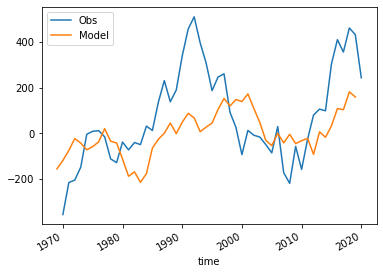

In [18]:
import matplotlib.pyplot as plt

# Set up a figure
fig, ax = plt.subplots()

# Plot the obs NAO
obs_nao.plot(ax=ax, label="Obs")

# Plot the model NAO
model_nao_ens_mean.plot(ax=ax, label="Model")

# Add a legend
ax.legend()

NAO looks approximately correct (but we also need to align the years), now we want to find the ensemble members which have the closest values to the signal adjusted NAO each year.

In [19]:
%%time

# For each year, calculate the absolute difference between the NAO of each
# of the ensemble members and the signal adjusted ensemble mean
# Then we want to create an ascending list of the ensemble members and their
# differences from the signal adjusted ensemble mean, from smallest to largest
# Then we want to calculate the rank of each ensemble member in this list

# Calculate the absolute difference between the NAO of each of the ensemble
# members and the signal adjusted ensemble mean
# Set up the years
years = model_nao['time.year'].values

# Extract the values for the data
model_nao_values = model_nao['psl'].values

# Extract the model

# limit years for testing
years = years[:10]

# Set up a list to store the ranks
rank_list = {year: [] for year in years}

# Loop over the years
for i, year in tqdm(enumerate(years)):
    # Get the ensemble members for the year
    year_ens = model_nao_values[i, :]

    # print the types
    print(type(year_ens))
    print(type(model_nao_ens_mean[i].values))

    # Calculate the absolute difference
    abs_diff = np.abs(year_ens - model_nao_ens_mean[i].values)

    # Create a dataframe
    df = pd.DataFrame(
        {
            "ensemble_member": model_nao['ensemble_member'].values,
            "abs_diff": abs_diff,
        }
    )

    # Sort the dataframe by the absolute difference
    df = df.sort_values(by="abs_diff")

    # Add the dataframe to the rank list
    rank_list[year] = df


0it [00:00, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


1it [00:47, 47.57s/it]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


2it [01:03, 28.85s/it]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


3it [01:21, 23.78s/it]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


4it [01:36, 20.63s/it]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


5it [01:51, 18.43s/it]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


6it [02:03, 16.29s/it]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


7it [02:15, 14.99s/it]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


8it [02:28, 14.29s/it]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


9it [02:42, 14.10s/it]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


10it [02:56, 17.62s/it]

CPU times: user 1min 59s, sys: 20.2 s, total: 2min 19s
Wall time: 4min 31s


In [20]:
rank_list[1974] 

,ensemble_member,abs_diff
1,BCC-CSM2-MR_r1i1p1f1_lag_1,12.960655
24,BCC-CSM2-MR_r7i1p1f1_lag_0,18.716873
12,BCC-CSM2-MR_r4i1p1f1_lag_0,24.281776
30,BCC-CSM2-MR_r8i1p1f1_lag_2,26.232132
8,BCC-CSM2-MR_r3i1p1f1_lag_0,27.840500
29,BCC-CSM2-MR_r8i1p1f1_lag_1,28.132687
3,BCC-CSM2-MR_r1i1p1f1_lag_3,31.814125
17,BCC-CSM2-MR_r5i1p1f1_lag_1,38.674072
20,BCC-CSM2-MR_r6i1p1f1_lag_0,56.681355
2,BCC-CSM2-MR_r1i1p1f1_lag_2,57.636269


#### Matching for the variable ####

Now we want to pick a variable to match for, say, sfcWind. Then we want to find the ensemble members within the sfcWind ensemble which correspond to the 20 highest ranked members in the ranked list. First we want to assemble the ensemble list for this variable.

In [21]:
# Define a function for finding the ensemble members for a given variable
def find_ens_members(
                variable: str,
                models_list: list,
                season: str,
                forecast_range: str,
                start_year: int = 1961,
                end_year: int = 2014,
                lag: int = 4,
                region: str = "global",
                base_dir: str = "/gws/nopw/j04/canari/users/benhutch/skill-maps-processed-data",
):
        """
        Forms a list of all of the ensemble members for a given variable.

        Args:
                variable (str): The variable to find the ensemble members for.
                models_list (list): A list of the models to find the ensemble members for.
                start_year (int): The start year of the data.
                end_year (int): The end year of the data.
                region (str): The region to find the ensemble members for.
                base_dir (str): The base directory of the data.

        Returns:
                ens_members (list): A list of the ensemble members for the given variable.
        """

        # Set up a list to store the ensemble members
        ens_members = []

        # Loop over the models
        for model in tqdm(models_list):
                # Set up the fstem
                fstem = (
                        f"{base_dir}/{variable}/{model}/{region}/{forecast_range}/{season}/outputs/"
                )
                                
                # Set up the filename
                fname = f"*s{start_year}-*years_{forecast_range}_start_{start_year}_end_{end_year}_anoms.nc"

                # Find the files
                files = glob.glob(f"{fstem}{fname}")

                # Extract the filenames
                fnames = [file.split("/")[-1] for file in files]

                # Split the fnames by _
                fnames_split = [fname.split("_")[4] for fname in fnames]

                # Split this list by -
                members = [fname.split("-")[1] for fname in fnames_split]

                # Find the unique members
                unique_members = list(set(members))

                # New members list
                new_members = []

                if lag is not None:
                        for lag_idx in range(lag):
                                # append the model to the members
                                new_members += [f"{model}_{member}_lag_{lag_idx}" for member in unique_members]
                else:
                        # append the model to the members
                        #f"{model}_{member}" for member in members
                        new_members = [f"{model}_{member}" for member in members]

                # Add the members to the list
                ens_members.extend(new_members)

        return ens_members


In [22]:
# Import dictionaries
sys.path.append('/home/users/benhutch/lagging-NAO-test-suite/')

# Import dictionaries
import dictionaries as dicts

In [23]:
# test this function
sfcwind_ens = find_ens_members(
    variable="sfcWind",
    models_list=dicts.sfcWind_models,
    season="ONDJFM",
    forecast_range="2-9",
    start_year=1961,
    end_year=2014,
    region="global",
    base_dir="/gws/nopw/j04/canari/users/benhutch/skill-maps-processed-data",
)

 44%|████▍     | 4/9 [00:00<00:00, 36.87it/s]

100%|██████████| 9/9 [00:00<00:00, 35.90it/s]


In [24]:
len(sfcwind_ens)

524

In [25]:
# Write a function which finds the overlapping members
# between rank_list and sfcwind_ens and returns a list of
# the overlapping members
def find_overlapping_members(rank_list: dict,
                                ens_mems: list,
                                no_members: int = 20,):
    """
    Finds the overlapping members between the rank list and the sfcwind ensemble members.

    Args:
        rank_list (dict): A dictionary containing the ranks of the ensemble members.
        ens_mems (list): A list of the ensemble members for the variable.
        no_members (int): The number of members to return.

    Returns:
        overlapping_members (list): A list of the overlapping members.
    """

    # Set up a dictionary to store the overlapping members for each year
    overlapping_members = {year: [] for year in rank_list.keys()}

    # Loop over the years in the rank list
    for year in rank_list:
        # Get the ensemble members for the year, sorted in descending order
        year_df = rank_list[year]

        # Sort this dataframe by the absolute difference
        year_df = year_df.sort_values(by="abs_diff")

        # Loop over the ensemble members
        for member in year_df["ensemble_member"]:
            # Check if the member is in the sfcwind ensemble members
            if member in sfcwind_ens:
                # Add the member to the overlapping members for the year
                overlapping_members[year].append(member)
                # If we have found 20 members for the year, stop looking
                if len(overlapping_members[year]) == 20:
                    break

    return overlapping_members

Now that we have this list, we want to find the members which match those within the nao rank_list for each year, then we need to extract these.

In [30]:
# Test the new function
ovelap_mem = find_overlapping_members(rank_list, sfcwind_ens)

In [31]:
ovelap_mem[1974]

['BCC-CSM2-MR_r1i1p1f1_lag_1',
 'BCC-CSM2-MR_r7i1p1f1_lag_0',
 'BCC-CSM2-MR_r4i1p1f1_lag_0',
 'BCC-CSM2-MR_r8i1p1f1_lag_2',
 'BCC-CSM2-MR_r3i1p1f1_lag_0',
 'BCC-CSM2-MR_r8i1p1f1_lag_1',
 'BCC-CSM2-MR_r1i1p1f1_lag_3',
 'BCC-CSM2-MR_r5i1p1f1_lag_1',
 'BCC-CSM2-MR_r6i1p1f1_lag_0',
 'BCC-CSM2-MR_r1i1p1f1_lag_2',
 'BCC-CSM2-MR_r6i1p1f1_lag_2',
 'BCC-CSM2-MR_r4i1p1f1_lag_3',
 'BCC-CSM2-MR_r7i1p1f1_lag_2',
 'BCC-CSM2-MR_r2i1p1f1_lag_3',
 'BCC-CSM2-MR_r7i1p1f1_lag_3',
 'BCC-CSM2-MR_r8i1p1f1_lag_0',
 'BCC-CSM2-MR_r3i1p1f1_lag_2',
 'BCC-CSM2-MR_r6i1p1f1_lag_3',
 'BCC-CSM2-MR_r2i1p1f1_lag_2',
 'BCC-CSM2-MR_r1i1p1f1_lag_0']

Now that we have this, we can find the matching anoms files for each year. Define a function for extracting this.

In [74]:
# Define a function for finding the ensemble members for a given variable
def find_matched_members(
    overlap_mem: dict,
    variable: str,
    forecast_range: str,
    season: str,
    n_matched_mems = 20,
    start_year: int = 1961,
    end_year: int = 2014,
    lag: int = 4,
    region: str = "global",
    alt_lag: bool = False,
    base_dir: str = "/gws/nopw/j04/canari/users/benhutch/skill-maps-processed-data",
    ):
    """
    Finds the ensemble member for a given variable that matches the overlapping members.
    These overlapping members are the ones that are closest to the signal adjusted ensemble mean
    for the NAO index, which are also present in the matched variables ensemble members.

    Args:
            overlap_mem (dict): A dictionary containing the overlapping members for the variable.
            variable (str): The variable to find the matched member for.
            forecast_range (str): The forecast range of the data.
            season (str): The season of the data.
            n_matched_mems (int): The number of matched members to return.
            start_year (int): The start year of the data.
            end_year (int): The end year of the data.
            region (str): The region of the data.
            alt_lag (bool): Whether to use the alternate lag suite.
            base_dir (str): The base directory of the data.

    Returns:
            matched_member (dict): A dictionary containing the matched member for the variable.
    """

    # If alt_lag is True, we want to use the alternate lag suite
    if forecast_range in ["1", "2"]:
        # Set up the base directory
        AssertionError("Alternate lag suite not yet implemented")

    # Set up the years
    years = list(overlap_mem.keys())

    # Extract the first lag 0 file, for the first year
    # To get the dimensions of the data (lat, lon)
    # Set up the fstem
    members = overlap_mem[years[0]]

    # Constrain members to those with lag_0
    test_member = [member for member in members if 'lag_0' in member][0]

    # # Print the member
    # print("test member: ", test_member)

    # Set up the model
    model = test_member.split("_")[0]
    member = test_member.split("_")[1]

    # Set up the fstem
    fstem = (
        f"{base_dir}/{variable}/{model}/{region}/{forecast_range}/{season}/outputs/"
    )

    # Set up the fname
    fname = f"all-years*_s{years[0]}-{member}*years_{forecast_range}_start_{start_year}_end_{end_year}_anoms.nc"

    # # Print the path
    # print(f"{fstem}{fname}")

    # Find the files
    first_file = glob.glob(f"{fstem}{fname}")[0]
    
    # # Print the first file
    # print("first file: ", first_file)

    # Open the file
    first_ds = xr.open_dataset(first_file,
                                chunks={"time": 'auto', "lat": 'auto', "lon": 'auto'},
                                engine="netcdf4")

    # Extract the dimensions
    lats = first_ds['lat'].values
    lons = first_ds['lon'].values

    # Close the dataset
    first_ds.close()

    # Set up the array
    # LIke (20, 54, 72, 144)
    # After taking the avg. over the time window
    matched_mem_arr = np.zeros([n_matched_mems, len(years), len(lats), len(lons)])

    # SHift the years lift by the offset
    if forecast_range == "2-9":
        years = [year - 5 for year in years]
        df_offset = 5
    elif forecast_range == "2-5":
        # FIXME: Check this
        years = [year - 3 for year in years]
        df_offset = 3
    else:
        # Assertion error, forecast range not recognised
        assert False, "Forecast range not recognised"

    # Loop over the years
    for i, year in enumerate(tqdm(years, desc="Extracting NAO matched members for year: ")):
        print("year: ", year)
        # Get the overlapping members for the year
        year_df = overlap_mem[year + df_offset]

        # Loop over the members
        for j, member in enumerate(year_df):
            
            
            # Set up the fstem
            model = member.split("_")[0]
            member_id = member.split("_")[1]
            lag_idx = int(member.split("_")[3])

            # Print the components
            print("model: ", model, "member: ", member_id, "lag_idx: ", lag_idx)

            # Set up the fstem
            fstem = (
                f"{base_dir}/{variable}/{model}/{region}/{forecast_range}/{season}/outputs/"
            )

            # Set up the s{year}, depending on the lag index
            # E.g. for 1964, lag 0, we want s1964
            # E.g. for 1964, lag 1, we want s1963
            # Asser that the lag index is an integer
            assert isinstance(lag_idx, int)

            # Set up the year
            init_year = year - lag_idx

            if season in ["DJF", "DJFM", "ONDJFM"]:    
                # Set up the fname
                fname = f"all-years*_s{init_year}-{member_id}*years_{forecast_range}_start_{start_year}_end_{end_year}_anoms.nc"
            else:
                # Extract the first digit in forecast range
                first_digit = forecast_range.split("-")[0]
                last_digit = forecast_range.split("-")[1]

                # Set up the forecast range
                forecast_range_sum = f"{first_digit + 1}-{last_digit + 1}"

                # Set up the fname
                fname = f"{variable}_s{init_year}-{member_id}*years_{forecast_range_sum}_start_{start_year}_end_{end_year}_anoms.nc"

            # Set up the start year and end year indices
            if "-" in forecast_range:
                start_year_idx = int(forecast_range.split("-")[0])
                end_year_idx = int(forecast_range.split("-")[1])
            else:
                start_year_idx = int(forecast_range)
                end_year_idx = int(forecast_range)

            # If the model name is BCC-CSM2-MR, we need to set up the indexes differently
            # If the model name is BCC-CSM2-MR
            if model == "BCC-CSM2-MR":
                # Set the start year index
                start_year_idx = start_year_idx
                # Set the end year index
                end_year_idx = end_year_idx + 1  # jan of this year
            else:
                # Set the start year index
                start_year_idx = start_year_idx - 1

                # Set the end year index
                end_year_idx = end_year_idx - 1 + 1  # jan of this year


            # Find the files
            file = glob.glob(f"{fstem}{fname}")

            # Assert that the length of the file is 1
            assert len(file) == 1, f"Length of file is not 1, it is {len(file)}"

            # Print the loading file
            print(f"Loading file: {file[0].split('/')[-1]}")

            # Open the dataset
            ds = xr.open_dataset(file[0],
                                 chunks={"time": 'auto', "lat": 'auto', "lon": 'auto'},
                                engine="netcdf4")

            # Extract the years
            years = ds.time.dt.year.values

            # Find the unique years
            unique_years = np.unique(years)

            # Extract the first year
            first_year = int(unique_years[start_year_idx])
            last_year = int(unique_years[end_year_idx])

                # If the forecast range is years 2-9
            if forecast_range == "2-9":
                # Form the strings for the start and end dates
                start_date = f"{first_year}-01-01"
                end_date = f"{last_year}-01-01"
            elif forecast_range == "2-5":
                # Form the strings for the start and end dates depending on the lag
                if lag_idx == 0:
                    start_date = f"{first_year}-01-01"
                    end_date = f"{first_year}-01-01"
                else:
                    start_date = f"{first_year + lag_idx}-01-01"
                    end_date = f"{last_year + lag_idx}-01-01"
            else:
                # Assertion error, forecast range not recognised
                assert False, "Forecast range not recognised"

            # Take the mean over the time dimension between the start and end dates
            ds = ds.sel(time=slice(start_date, end_date)).mean("time")
    
            # Extract the values
            vals = ds[variable].values
    
            # Add the values to the array
            matched_mem_arr[j, i, :, :] = vals

            # Close the dataset
            ds.close()

    # Return the array
    return matched_mem_arr

In [75]:
matched_sfcwind_arr = find_matched_members(
    overlap_mem=ovelap_mem,
    variable="sfcWind",
    forecast_range="2-9",
    season="ONDJFM",
    n_matched_mems=20,
    start_year=1961,
    end_year=2014,
    lag=4,
    region="global",
    alt_lag=False,
    base_dir="/gws/nopw/j04/canari/users/benhutch/skill-maps-processed-data",
)

Extracting NAO matched members for year:   0%|          | 0/10 [00:00<?, ?it/s]

year:  1964
model:  BCC-CSM2-MR member:  r3i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1962-r3i1p1f1_gn_196201-197112_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r1i1p1f1 lag_idx:  1
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1963-r1i1p1f1_gn_196301-197212_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r7i1p1f1 lag_idx:  3
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1961-r7i1p1f1_gn_196101-197012_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r2i1p1f1 lag_idx:  0
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1964-r2i1p1f1_gn_196401-197312_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r5i1p1f1 lag_idx:  3
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1961-r5i1p1f1_gn_196101-197012_years_2-9_start_1961_end_2014_an

Extracting NAO matched members for year:  10%|█         | 1/10 [00:08<01:20,  8.97s/it]

model:  BCC-CSM2-MR member:  r1i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1962-r1i1p1f1_gn_196201-197112_years_2-9_start_1961_end_2014_anoms.nc
year:  1965
model:  BCC-CSM2-MR member:  r6i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1963-r6i1p1f1_gn_196301-197212_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r2i1p1f1 lag_idx:  3
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1962-r2i1p1f1_gn_196201-197112_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r6i1p1f1 lag_idx:  1
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1964-r6i1p1f1_gn_196401-197312_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r8i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1963-r8i1p1f1_gn_196301-197212_years_2-9_start_1961_end_2014_an

Extracting NAO matched members for year:  20%|██        | 2/10 [00:11<00:39,  5.00s/it]

model:  BCC-CSM2-MR member:  r1i1p1f1 lag_idx:  1
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1964-r1i1p1f1_gn_196401-197312_years_2-9_start_1961_end_2014_anoms.nc
year:  1966
model:  BCC-CSM2-MR member:  r4i1p1f1 lag_idx:  1
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1965-r4i1p1f1_gn_196501-197412_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r5i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1964-r5i1p1f1_gn_196401-197312_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r1i1p1f1 lag_idx:  0
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1966-r1i1p1f1_gn_196601-197512_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r8i1p1f1 lag_idx:  3
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1963-r8i1p1f1_gn_196301-197212_years_2-9_start_1961_end_2014_an

Extracting NAO matched members for year:  30%|███       | 3/10 [00:11<00:20,  2.94s/it]

Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1966-r6i1p1f1_gn_196601-197512_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r3i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1964-r3i1p1f1_gn_196401-197312_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r1i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1964-r1i1p1f1_gn_196401-197312_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r7i1p1f1 lag_idx:  3
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1963-r7i1p1f1_gn_196301-197212_years_2-9_start_1961_end_2014_anoms.nc
year:  1967
model:  BCC-CSM2-MR member:  r3i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1965-r3i1p1f1_gn_196501-197412_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r2i1p1f1 lag_i

Extracting NAO matched members for year:  40%|████      | 4/10 [00:12<00:12,  2.12s/it]

Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1967-r5i1p1f1_gn_196701-197612_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r4i1p1f1 lag_idx:  1
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1966-r4i1p1f1_gn_196601-197512_years_2-9_start_1961_end_2014_anoms.nc
year:  1968
model:  BCC-CSM2-MR member:  r8i1p1f1 lag_idx:  0
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1968-r8i1p1f1_gn_196801-197712_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r1i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1966-r1i1p1f1_gn_196601-197512_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r8i1p1f1 lag_idx:  1
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1967-r8i1p1f1_gn_196701-197612_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r2i1p1f1 lag_i

Extracting NAO matched members for year:  50%|█████     | 5/10 [00:13<00:08,  1.68s/it]

model:  BCC-CSM2-MR member:  r1i1p1f1 lag_idx:  3
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1965-r1i1p1f1_gn_196501-197412_years_2-9_start_1961_end_2014_anoms.nc
year:  1969
model:  BCC-CSM2-MR member:  r1i1p1f1 lag_idx:  1
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1968-r1i1p1f1_gn_196801-197712_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r7i1p1f1 lag_idx:  0
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1969-r7i1p1f1_gn_196901-197812_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r4i1p1f1 lag_idx:  0
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1969-r4i1p1f1_gn_196901-197812_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r8i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1967-r8i1p1f1_gn_196701-197612_years_2-9_start_1961_end_2014_an

Extracting NAO matched members for year:  60%|██████    | 6/10 [00:13<00:05,  1.29s/it]

model:  BCC-CSM2-MR member:  r8i1p1f1 lag_idx:  0
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1969-r8i1p1f1_gn_196901-197812_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r3i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1967-r3i1p1f1_gn_196701-197612_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r6i1p1f1 lag_idx:  3
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1966-r6i1p1f1_gn_196601-197512_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r2i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1967-r2i1p1f1_gn_196701-197612_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r1i1p1f1 lag_idx:  0
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1969-r1i1p1f1_gn_196901-197812_years_2-9_start_1961_end_2014_anoms.nc
year:

Extracting NAO matched members for year:  70%|███████   | 7/10 [00:14<00:02,  1.01it/s]

model:  BCC-CSM2-MR member:  r2i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1968-r2i1p1f1_gn_196801-197712_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r2i1p1f1 lag_idx:  3
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1967-r2i1p1f1_gn_196701-197612_years_2-9_start_1961_end_2014_anoms.nc
year:  1971
model:  BCC-CSM2-MR member:  r6i1p1f1 lag_idx:  0
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1971-r6i1p1f1_gn_197101-198012_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r8i1p1f1 lag_idx:  3
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1968-r8i1p1f1_gn_196801-197712_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r4i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1969-r4i1p1f1_gn_196901-197812_years_2-9_start_1961_end_2014_an

Extracting NAO matched members for year:  80%|████████  | 8/10 [00:14<00:01,  1.16it/s]

model:  BCC-CSM2-MR member:  r8i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1969-r8i1p1f1_gn_196901-197812_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r8i1p1f1 lag_idx:  0
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1971-r8i1p1f1_gn_197101-198012_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r3i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1969-r3i1p1f1_gn_196901-197812_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r2i1p1f1 lag_idx:  1
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1970-r2i1p1f1_gn_197001-197912_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r5i1p1f1 lag_idx:  3
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1968-r5i1p1f1_gn_196801-197712_years_2-9_start_1961_end_2014_anoms.nc
model

Extracting NAO matched members for year:  90%|█████████ | 9/10 [00:19<00:02,  2.16s/it]

model:  BCC-CSM2-MR member:  r5i1p1f1 lag_idx:  1
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1971-r5i1p1f1_gn_197101-198012_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r3i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1970-r3i1p1f1_gn_197001-197912_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r3i1p1f1 lag_idx:  0
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1972-r3i1p1f1_gn_197201-198112_years_2-9_start_1961_end_2014_anoms.nc
model:  BCC-CSM2-MR member:  r1i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1970-r1i1p1f1_gn_197001-197912_years_2-9_start_1961_end_2014_anoms.nc
year:  1973
model:  BCC-CSM2-MR member:  r6i1p1f1 lag_idx:  2
Loading file: all-years-ONDJFM-global-sfcWind_Amon_BCC-CSM2-MR_dcppA-hindcast_s1971-r6i1p1f1_gn_197101-198012_years_2-9_start_1961_end_2014_an

Extracting NAO matched members for year: 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


In [76]:
print(matched_sfcwind_arr.shape)

(20, 10, 72, 144)


In [77]:
print(matched_sfcwind_arr)

[[[[-2.52049088e-01 -2.52049088e-01 -2.52049088e-01 ... -2.52049088e-01
    -2.52049088e-01 -2.52049088e-01]
   [-3.11452687e-01 -3.07181239e-01 -3.05600762e-01 ... -3.17750692e-01
    -3.14186156e-01 -3.13818753e-01]
   [-2.10155129e-01 -2.05850840e-01 -2.02961683e-01 ... -2.28638828e-01
    -2.22377837e-01 -2.15911508e-01]
   ...
   [ 3.76564264e-02  3.43875289e-02  3.62866819e-02 ...  3.08279097e-02
     3.26061547e-02  3.39555144e-02]
   [-2.48591900e-02 -2.93177962e-02 -3.34101021e-02 ... -1.27186179e-02
    -1.96827054e-02 -2.26470828e-02]
   [-5.50604463e-02 -5.63075542e-02 -5.70166707e-02 ... -5.19906282e-02
    -5.45357764e-02 -5.40909767e-02]]

  [[-6.87088966e-02 -6.87088966e-02 -6.87088966e-02 ... -6.87088966e-02
    -6.87088966e-02 -6.87088966e-02]
   [-3.09429169e-02 -2.83259153e-02 -2.55019069e-02 ... -4.15948629e-02
    -3.79714370e-02 -3.48603129e-02]
   [-9.04226303e-03 -1.29842758e-03  3.49867344e-03 ... -3.06591988e-02
    -2.36160755e-02 -1.59860849e-02]
   ...
   